# Introdu√ß√£o

Este projeto tem como objetivo analisar dados cl√≠nicos relacionados √† falha card√≠aca (heart failure) para identificar padr√µes que auxiliem na predi√ß√£o do risco de √≥bito dos pacientes. A falha card√≠aca √© uma condi√ß√£o grave que afeta a capacidade do cora√ß√£o de bombear sangue adequadamente, e a detec√ß√£o precoce pode melhorar significativamente o manejo cl√≠nico e os resultados para os pacientes. Utilizando t√©cnicas de an√°lise explorat√≥ria de dados (EDA) e aprendizado de m√°quina, buscamos entender as caracter√≠sticas mais relevantes e construir modelos preditivos eficientes para apoiar decis√µes m√©dicas.

## Informa√ß√µes do conjunto de dados

1 - Age: idade do paciente [anos]\
2 - Sex: sexo do paciente [M: Masculino, F: Feminino]\
3 - ChestPainType: tipo de dor tor√°cica [TA: Angina t√≠pica, ATA: Angina at√≠pica, NAP: Dor n√£o anginosa, ASY: Assintom√°tica]\
4 - ResgingBP: press√£o arterial em repouso [mm Hg]\
5- Cholesterol: colesterol s√©rico [mm/dl]\
6- FastingBS: glicemia em jejum [1: se BS em jejum > 120 mg/dl, 0: caso contr√°rio]\
7 - ResgingECG: resultados do eletrocardiograma em repouso [Normal: Normal, ST: com anormalidade das ondas ST-T (invers√µes das ondas T e/ou eleva√ß√£o ou depress√£o de ST > 0,05 mV), HVE: mostrando hipertrofia ventricular esquerda prov√°vel ou definitiva pelos crit√©rios de testes]\
8 - MaxHR: frequ√™ncia card√≠aca m√°xima alcan√ßada [valor num√©rico entre 60 e 202]\
9 - Exerc√≠cioAngina: angina induzida por exerc√≠cio [Y: Sim, N: N√£o]\
10 - Oldpeak: oldpeak = ST [Valor num√©rico medido na depress√£o]\
11 - ST_Slope: a inclina√ß√£o do segmento ST do pico do exerc√≠cio [Up: subida, Flat: flat, Down: downsloping]\
12 - HeartDisease: classe de sa√≠da [1: doen√ßa card√≠aca, 0: Normal]\

In [115]:
# Importando os pacotes que ser√£o utilizados

import warnings
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import time
import seaborn as sns
from scipy.stats import chi2_contingency,ttest_ind
from sklearn.model_selection import train_test_split,StratifiedKFold,cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
import shap
from sklearn.metrics import roc_curve, auc, confusion_matrix, ConfusionMatrixDisplay

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
warnings.filterwarnings("ignore")
pd.options.display.float_format = '{:.2f}'.format


# Metodologia

Inicialmente, realizamos uma an√°lise explorat√≥ria dos dados para verificar distribui√ß√µes, valores ausentes, outliers e poss√≠veis correla√ß√µes entre as vari√°veis cl√≠nicas e o desfecho (√≥bito). Em seguida, aplicamos transforma√ß√µes necess√°rias, como codifica√ß√£o de vari√°veis categ√≥ricas e normaliza√ß√£o, para preparar os dados para modelagem.

Foram treinados diferentes modelos de classifica√ß√£o, incluindo regress√£o log√≠stica, Random Forest e XGBoost, com avalia√ß√£o utilizando m√©tricas como acur√°cia, precis√£o, recall, F1-score e AUC-ROC. Para interpretar os resultados dos modelos, utilizamos a ferramenta SHAP para identificar as vari√°veis que mais influenciam as predi√ß√µes, permitindo maior transpar√™ncia e entendimento cl√≠nico dos fatores de risco.


In [84]:
# Carregando o arquivo CSV

df = pd.read_csv('/content/heart.csv')

In [85]:
# Verificando as primeiras linhas do DataFrame

df.head()

Age Sex ChestPainType  RestingBP  Cholesterol  FastingBS RestingECG  MaxHR  \
0   40   M           ATA        140          289          0     Normal    172   
1   49   F           NAP        160          180          0     Normal    156   
2   37   M           ATA        130          283          0         ST     98   
3   48   F           ASY        138          214          0     Normal    108   
4   54   M           NAP        150          195          0     Normal    122   

  ExerciseAngina  Oldpeak ST_Slope  HeartDisease  
0              N     0.00       Up             0  
1              N     1.00     Flat             1  
2              N     0.00       Up             0  
3              Y     1.50     Flat             1  
4              N     0.00       Up             0

In [86]:
# Verificando as dimens√µes do arquivo.

df.shape

(918, 12)

In [87]:
# Verificando informa√ß√µes do arquivo

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 918 entries, 0 to 917
Data columns (total 12 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Age             918 non-null    int64  
 1   Sex             918 non-null    object 
 2   ChestPainType   918 non-null    object 
 3   RestingBP       918 non-null    int64  
 4   Cholesterol     918 non-null    int64  
 5   FastingBS       918 non-null    int64  
 6   RestingECG      918 non-null    object 
 7   MaxHR           918 non-null    int64  
 8   ExerciseAngina  918 non-null    object 
 9   Oldpeak         918 non-null    float64
 10  ST_Slope        918 non-null    object 
 11  HeartDisease    918 non-null    int64  
dtypes: float64(1), int64(6), object(5)
memory usage: 86.2+ KB


In [88]:
# Verificando se h√° valores nulos (dados missing)

df.isnull().sum()

Age               0
Sex               0
ChestPainType     0
RestingBP         0
Cholesterol       0
FastingBS         0
RestingECG        0
MaxHR             0
ExerciseAngina    0
Oldpeak           0
ST_Slope          0
HeartDisease      0
dtype: int64

In [89]:
# Total de valores √∫nicos de cada vari√°vel

valores_unicos = []
for i in df.columns[0:12].tolist():
    print(i, ':', len(df[i].astype(str).value_counts()))
    valores_unicos.append(len(df[i].astype(str).value_counts()))

Age : 50
Sex : 2
ChestPainType : 4
RestingBP : 67
Cholesterol : 222
FastingBS : 2
RestingECG : 3
MaxHR : 119
ExerciseAngina : 2
Oldpeak : 53
ST_Slope : 3
HeartDisease : 2


In [90]:
# Visualizando algumas medidas estatisticas.

df.describe()

Age  RestingBP  Cholesterol  FastingBS  MaxHR  Oldpeak  HeartDisease
count 918.00     918.00       918.00     918.00 918.00   918.00        918.00
mean   53.51     132.40       198.80       0.23 136.81     0.89          0.55
std     9.43      18.51       109.38       0.42  25.46     1.07          0.50
min    28.00       0.00         0.00       0.00  60.00    -2.60          0.00
25%    47.00     120.00       173.25       0.00 120.00     0.00          0.00
50%    54.00     130.00       223.00       0.00 138.00     0.60          1.00
75%    60.00     140.00       267.00       0.00 156.00     1.50          1.00
max    77.00     200.00       603.00       1.00 202.00     6.20          1.00

In [91]:
df.duplicated().sum()

np.int64(0)

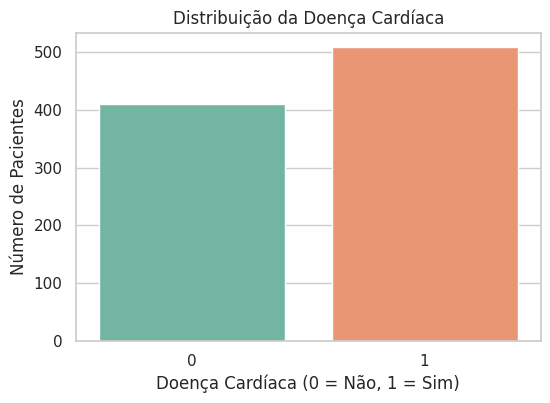

In [92]:
sns.set(style="whitegrid")

# Gr√°fico de barras da vari√°vel alvo
plt.figure(figsize=(6, 4))
sns.countplot(data=df, x='HeartDisease', palette='Set2')
plt.title("Distribui√ß√£o da Doen√ßa Card√≠aca")
plt.xlabel("Doen√ßa Card√≠aca (0 = N√£o, 1 = Sim)")
plt.ylabel("N√∫mero de Pacientes")
plt.show()

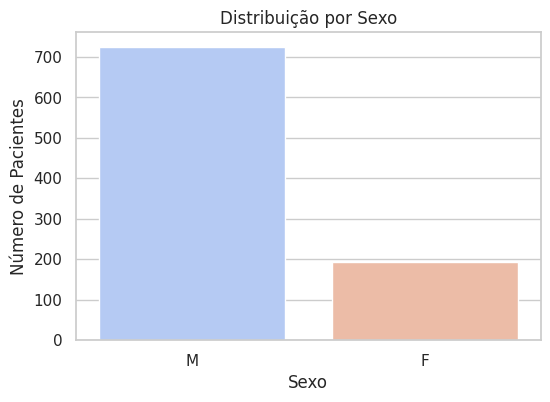

In [93]:
#Gr√°fico de barra da distribui√ß√£o da quantidade de pacientes agrupados por sexo
plt.figure(figsize=(6, 4))
sns.countplot(data=df, x='Sex', palette='coolwarm')
plt.title("Distribui√ß√£o por Sexo")
plt.xlabel("Sexo")
plt.ylabel("N√∫mero de Pacientes")
plt.show()

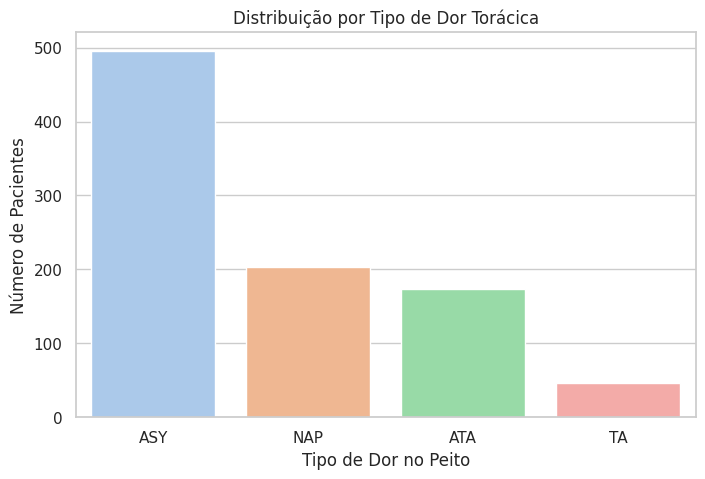

In [94]:
# Gr√°fico da distribui√ß√£o da quantidade de pacientes segundo o tipo de dor tor√°cica
plt.figure(figsize=(8, 5))
sns.countplot(data=df, x='ChestPainType', palette='pastel', order=df['ChestPainType'].value_counts().index)
plt.title("Distribui√ß√£o por Tipo de Dor Tor√°cica")
plt.xlabel("Tipo de Dor no Peito")
plt.ylabel("N√∫mero de Pacientes")
plt.show()

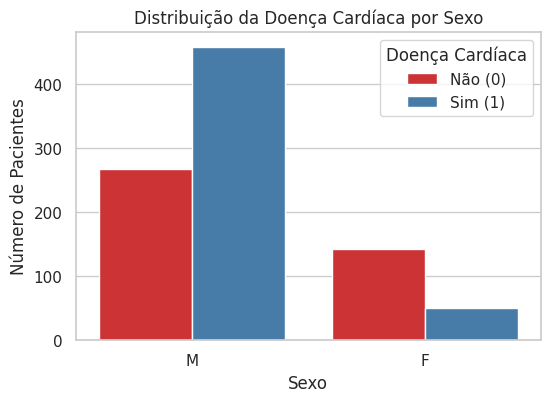

In [95]:
#Gr√°fico da distribui√ß√£o da presen√ßa de doen√ßa card√≠aca separada por sexo
plt.figure(figsize=(6, 4))
sns.countplot(data=df, x='Sex', hue='HeartDisease', palette='Set1')
plt.title("Distribui√ß√£o da Doen√ßa Card√≠aca por Sexo")
plt.xlabel("Sexo")
plt.ylabel("N√∫mero de Pacientes")
plt.legend(title='Doen√ßa Card√≠aca', labels=['N√£o (0)', 'Sim (1)'])
plt.show()

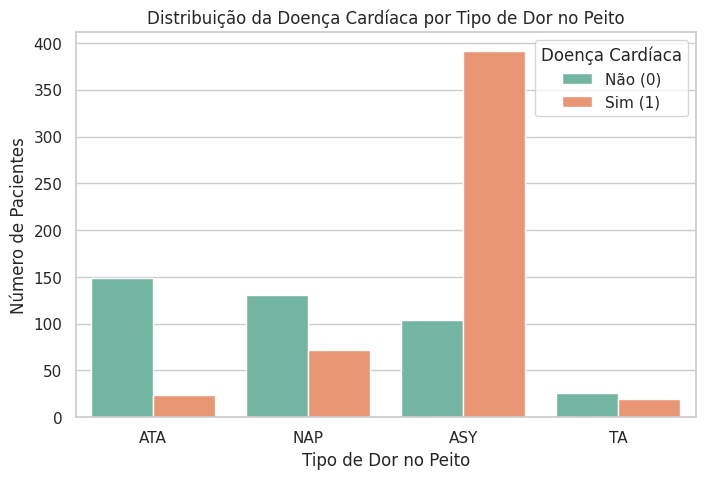

In [96]:
#Gr√°fico da distribui√ß√£o da presen√ßa de doen√ßa card√≠aca de acordo com o tipo de dor tor√°cica
plt.figure(figsize=(8, 5))
sns.countplot(data=df, x='ChestPainType', hue='HeartDisease', palette='Set2')
plt.title("Distribui√ß√£o da Doen√ßa Card√≠aca por Tipo de Dor no Peito")
plt.xlabel("Tipo de Dor no Peito")
plt.ylabel("N√∫mero de Pacientes")
plt.legend(title='Doen√ßa Card√≠aca', labels=['N√£o (0)', 'Sim (1)'])
plt.show()

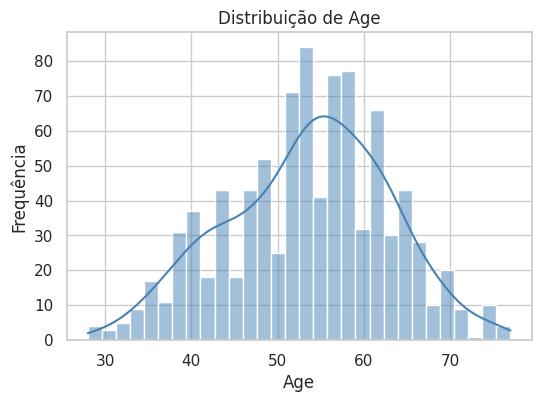

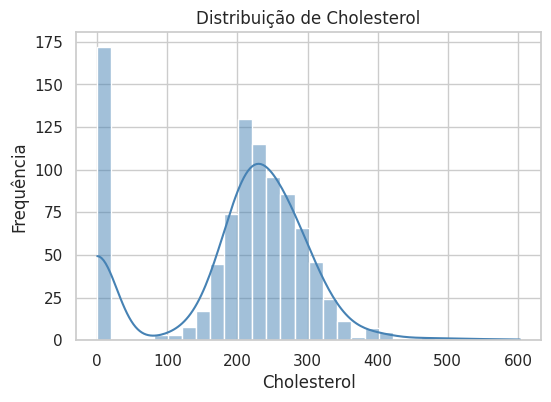

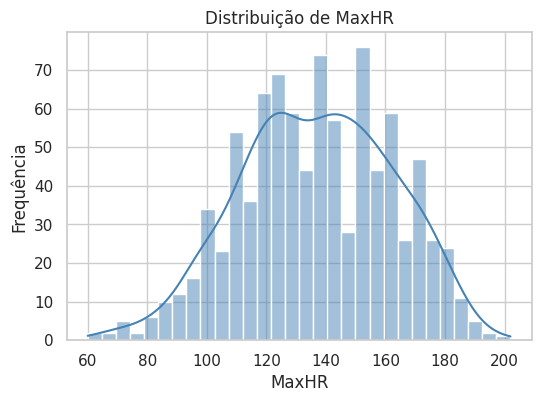

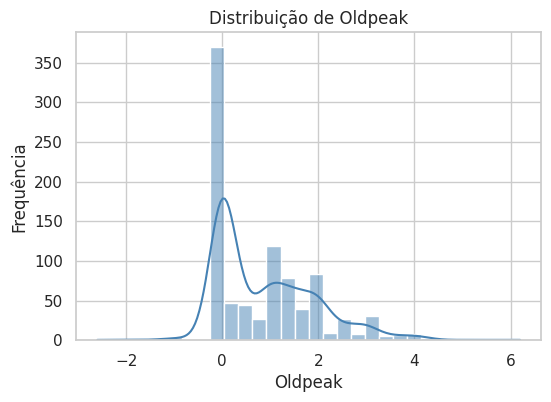

In [97]:
num_cols = ['Age', 'Cholesterol', 'MaxHR', 'Oldpeak']

# Plots
for col in num_cols:
    plt.figure(figsize=(6, 4))
    sns.histplot(data=df, x=col, kde=True, bins=30, color='steelblue')
    plt.title(f'Distribui√ß√£o de {col}')
    plt.xlabel(col)
    plt.ylabel('Frequ√™ncia')
    plt.show()

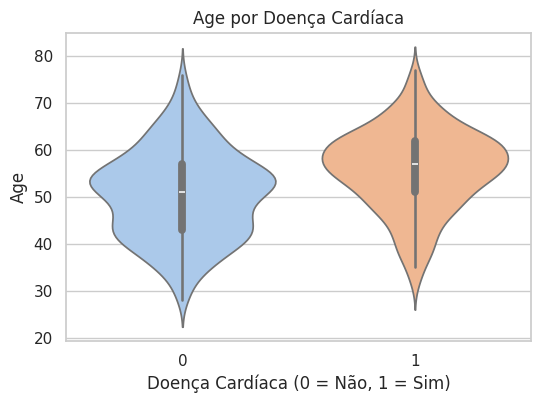

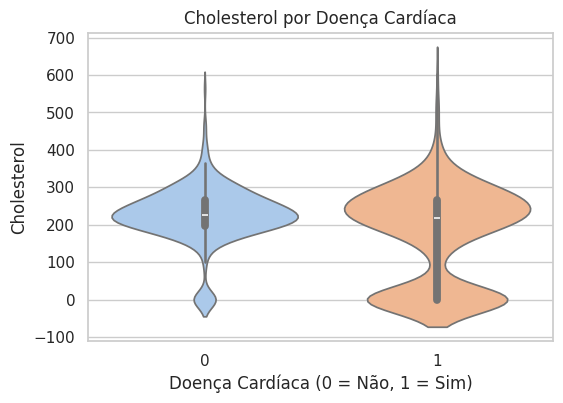

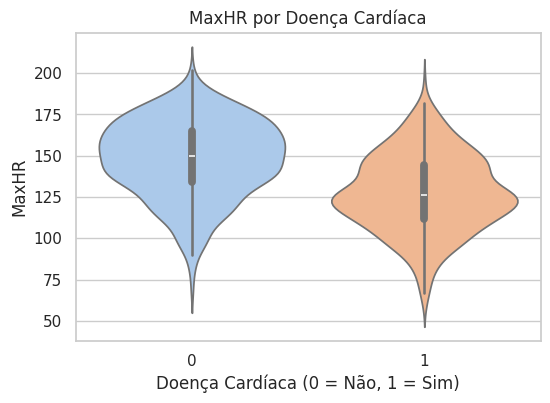

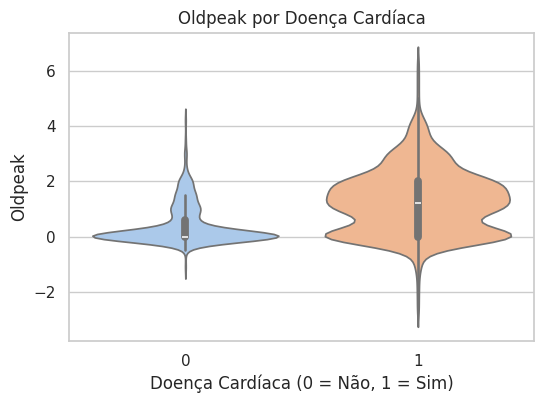

In [98]:
for col in ['Age', 'Cholesterol', 'MaxHR', 'Oldpeak']:
    plt.figure(figsize=(6, 4))
    sns.violinplot(x='HeartDisease', y=col, data=df, palette='pastel')
    plt.title(f'{col} por Doen√ßa Card√≠aca')
    plt.xlabel('Doen√ßa Card√≠aca (0 = N√£o, 1 = Sim)')
    plt.ylabel(col)
    plt.show()

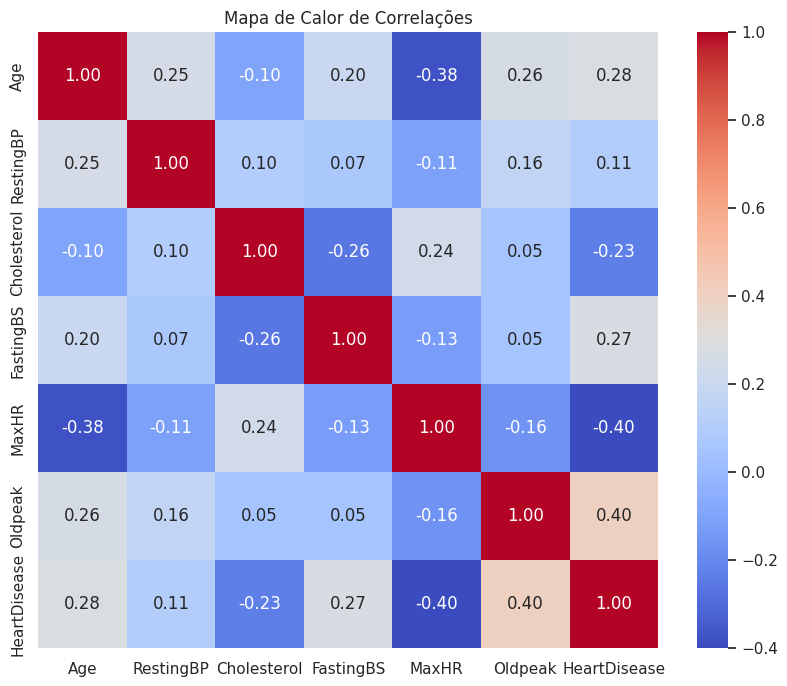

In [99]:
#Mapa de correla√ß√µes
plt.figure(figsize=(10, 8))
sns.heatmap(df.corr(numeric_only=True), annot=True, cmap='coolwarm', fmt='.2f')
plt.title("Mapa de Calor de Correla√ß√µes")
plt.show()

In [100]:
freq_table = pd.crosstab(df['ChestPainType'], df['HeartDisease'], normalize='index') * 100
print(freq_table.round(2))

HeartDisease      0     1
ChestPainType            
ASY           20.97 79.03
ATA           86.13 13.87
NAP           64.53 35.47
TA            56.52 43.48


In [101]:
cat_vars = ['Sex', 'ChestPainType', 'ST_Slope', 'RestingECG', 'ExerciseAngina', 'FastingBS']

for var in cat_vars:
    tabela = pd.crosstab(df[var], df['HeartDisease'])
    stat, p, dof, expected = chi2_contingency(tabela)
    print(f"\n Vari√°vel: {var}")
    print(f"Estat√≠stica Qui-quadrado: {stat:.2f}")
    print(f"p-valor: {p:.4f}")
    if p < 0.05:
        print("Associa√ß√£o significativa com Doen√ßa Card√≠aca")
    else:
        print("Sem associa√ß√£o significativa")


 Vari√°vel: Sex
Estat√≠stica Qui-quadrado: 84.15
p-valor: 0.0000
Associa√ß√£o significativa com Doen√ßa Card√≠aca

 Vari√°vel: ChestPainType
Estat√≠stica Qui-quadrado: 268.07
p-valor: 0.0000
Associa√ß√£o significativa com Doen√ßa Card√≠aca

 Vari√°vel: ST_Slope
Estat√≠stica Qui-quadrado: 355.92
p-valor: 0.0000
Associa√ß√£o significativa com Doen√ßa Card√≠aca

 Vari√°vel: RestingECG
Estat√≠stica Qui-quadrado: 10.93
p-valor: 0.0042
Associa√ß√£o significativa com Doen√ßa Card√≠aca

 Vari√°vel: ExerciseAngina
Estat√≠stica Qui-quadrado: 222.26
p-valor: 0.0000
Associa√ß√£o significativa com Doen√ßa Card√≠aca

 Vari√°vel: FastingBS
Estat√≠stica Qui-quadrado: 64.32
p-valor: 0.0000
Associa√ß√£o significativa com Doen√ßa Card√≠aca


In [102]:
num_vars = ['Age', 'Cholesterol', 'MaxHR', 'Oldpeak', 'RestingBP']

for var in num_vars:
    doente = df[df['HeartDisease'] == 1][var]
    saudavel = df[df['HeartDisease'] == 0][var]
    stat, p = ttest_ind(doente, saudavel, nan_policy='omit')
    print(f"\n Vari√°vel: {var}")
    print(f"Estat√≠stica t: {stat:.2f}")
    print(f"p-valor: {p:.4f}")
    if p < 0.05:
        print("Diferen√ßa significativa entre os grupos")
    else:
        print("Sem diferen√ßa significativa entre os grupos")


 Vari√°vel: Age
Estat√≠stica t: 8.90
p-valor: 0.0000
Diferen√ßa significativa entre os grupos

 Vari√°vel: Cholesterol
Estat√≠stica t: -7.24
p-valor: 0.0000
Diferen√ßa significativa entre os grupos

 Vari√°vel: MaxHR
Estat√≠stica t: -13.23
p-valor: 0.0000
Diferen√ßa significativa entre os grupos

 Vari√°vel: Oldpeak
Estat√≠stica t: 13.36
p-valor: 0.0000
Diferen√ßa significativa entre os grupos

 Vari√°vel: RestingBP
Estat√≠stica t: 3.28
p-valor: 0.0011
Diferen√ßa significativa entre os grupos


 Interpreta√ß√£o dos Resultados Estat√≠sticos

 Crit√©rio de Signific√¢ncia (n√≠vel padr√£o: Œ± = 0.05)

- **p < 0.05**  
  ‚û§ Existe **diferen√ßa estatisticamente significativa** entre os grupos analisados.  
  ‚û§ A vari√°vel est√° **associada** com a presen√ßa de **doen√ßa card√≠aca**.

- **p ‚â• 0.05**  
  ‚û§ **N√£o h√° evid√™ncia estat√≠stica suficiente** para afirmar que os grupos s√£o diferentes.  
  ‚û§ A vari√°vel **n√£o apresenta associa√ß√£o significativa** com a presen√ßa de **doen√ßa card√≠aca**.

> O p-valor representa a probabilidade de observarmos os dados (ou algo mais extremo), assumindo que a **hip√≥tese nula** seja verdadeira (ou seja, que n√£o haja associa√ß√£o ou diferen√ßa entre os grupos).


In [103]:
X = df.drop('HeartDisease', axis=1)
y = df['HeartDisease']

# Codificar vari√°veis categ√≥ricas
X = pd.get_dummies(X, drop_first=True)
X_encoded = pd.get_dummies(X, drop_first=True)
# Treino/teste split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Padronizar vari√°veis num√©ricas
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [104]:
log_model = LogisticRegression(max_iter=1000)
knn_model = KNeighborsClassifier()
xgb_model = XGBClassifier(use_label_encoder=False, eval_metric='logloss')

# Treinamento
log_model.fit(X_train_scaled, y_train)
knn_model.fit(X_train_scaled, y_train)
xgb_model.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=None, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=None,
              n_jobs=None, num_parallel_tree=None, random_state=None, ...)

In [117]:
log_model = LogisticRegression(max_iter=1000)
knn_model = KNeighborsClassifier()
xgb_model = XGBClassifier(use_label_encoder=False, eval_metric='logloss')

# Valida√ß√£o Cruzada no conjunto de treino
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

models = {
    'Logistic Regression': log_model,
    'KNN': knn_model,
    'XGBoost': xgb_model
}

print("### Valida√ß√£o Cruzada (Treino) ###")
for name, model in models.items():
    scores = cross_val_score(model, X_train_scaled, y_train, cv=cv, scoring='roc_auc')
    print(f"{name} - AUC m√©dio CV: {scores.mean():.4f} ¬± {scores.std():.4f}")

# Treinar os modelos finais com o conjunto de treino completo
for model in models.values():
    model.fit(X_train_scaled, y_train)

print("\n### Avalia√ß√£o Final (Teste) ###")
for name, model in models.items():
    preds = model.predict(X_test_scaled)
    probas = model.predict_proba(X_test_scaled)[:, 1]

    print(f"\nüîπ {name}")
    print(f"Accuracy:  {accuracy_score(y_test, preds):.3f}")
    print(f"Precision: {precision_score(y_test, preds):.3f}")
    print(f"Recall:    {recall_score(y_test, preds):.3f}")
    print(f"F1 Score:  {f1_score(y_test, preds):.3f}")
    print(f"ROC AUC:   {roc_auc_score(y_test, probas):.3f}")

### Valida√ß√£o Cruzada (Treino) ###
Logistic Regression - AUC m√©dio CV: 0.9226 ¬± 0.0142
KNN - AUC m√©dio CV: 0.9026 ¬± 0.0107
XGBoost - AUC m√©dio CV: 0.9127 ¬± 0.0144

### Avalia√ß√£o Final (Teste) ###

üîπ Logistic Regression
Accuracy:  0.853
Precision: 0.900
Recall:    0.841
F1 Score:  0.870
ROC AUC:   0.927

üîπ KNN
Accuracy:  0.853
Precision: 0.900
Recall:    0.841
F1 Score:  0.870
ROC AUC:   0.924

üîπ XGBoost
Accuracy:  0.859
Precision: 0.901
Recall:    0.850
F1 Score:  0.875
ROC AUC:   0.923


# Compara√ß√£o de Modelos Preditivos para Diagn√≥stico de Doen√ßa Card√≠aca

Foram avaliados tr√™s modelos de classifica√ß√£o para prever a presen√ßa de doen√ßa card√≠aca, utilizando m√©tricas de desempenho comuns em aprendizado de m√°quina. Al√©m da avalia√ß√£o final no conjunto de teste, foi realizada uma valida√ß√£o cruzada no conjunto de treino para garantir a robustez dos resultados.

---

# Valida√ß√£o Cruzada (Treino)

| Modelo              | AUC m√©dio CV | Desvio Padr√£o CV |
|---------------------|--------------|------------------|
| Logistic Regression  | 0.9226       | ¬± 0.0142         |
| KNN                 | 0.9026       | ¬± 0.0107         |
| XGBoost             | 0.9127       | ¬± 0.0144         |

*Os resultados indicam que a regress√£o log√≠stica teve o melhor desempenho m√©dio e maior estabilidade durante as itera√ß√µes da valida√ß√£o cruzada.*

---

# Avalia√ß√£o Final (Teste)

| Modelo              | Accuracy | Precision | Recall | F1 Score | ROC AUC |
|---------------------|----------|-----------|--------|----------|---------|
| Logistic Regression  | 0.853    | 0.900     | 0.841  | 0.870    | 0.927   |
| KNN                 | 0.853    | 0.900     | 0.841  | 0.870    | 0.924   |
| XGBoost             | 0.859    | 0.901     | 0.850  | 0.875    | 0.923   |

---

# **Conclus√µes**

- **Logistic Regression** apresentou o melhor desempenho m√©dio na valida√ß√£o cruzada (AUC 0.9226), sugerindo boa generaliza√ß√£o e estabilidade no treino.
- Na avalia√ß√£o final, o **XGBoost** obteve a maior acur√°cia (0.859) e F1 Score (0.875), demonstrando ser o modelo com melhor desempenho pr√°tico no conjunto de teste, ainda que por margem pequena.
- Todos os modelos apresentaram **alto ROC AUC (> 0.92)**, indicando excelente capacidade de discrimina√ß√£o entre pacientes com e sem doen√ßa card√≠aca.
- **Logistic Regression** e **KNN** apresentaram desempenhos muito semelhantes, com √≥tima precis√£o e sensibilidade balanceadas, adequados para aplica√ß√µes cl√≠nicas que exigem menor complexidade computacional.


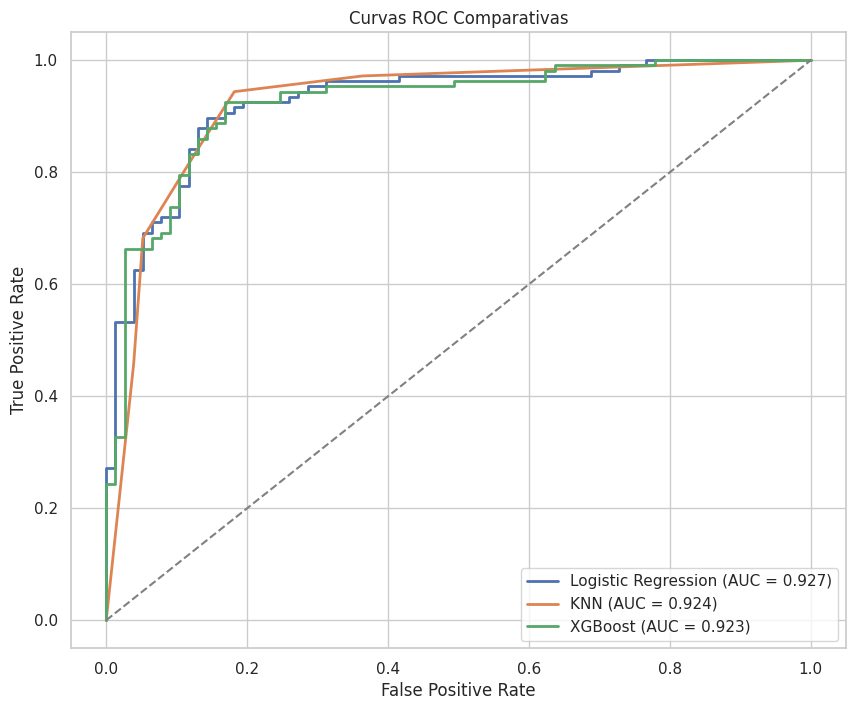

In [106]:
#Curva ROC dos modelos
models = {
    'Logistic Regression': log_model,
    'KNN': knn_model,
    'XGBoost': xgb_model
}

plt.figure(figsize=(10, 8))

for name, model in models.items():
    if name == 'XGBoost':
        y_proba = model.predict_proba(X_test)[:, 1]
        y_pred = model.predict(X_test)
    else:
        y_proba = model.predict_proba(X_test_scaled)[:, 1]
        y_pred = model.predict(X_test_scaled)

    # Curva ROC
    fpr, tpr, _ = roc_curve(y_test, y_proba)
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, lw=2, label=f'{name} (AUC = {roc_auc:.3f})')

plt.plot([0, 1], [0, 1], linestyle='--', color='gray')  # Linha base (aleat√≥rio)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Curvas ROC Comparativas')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()

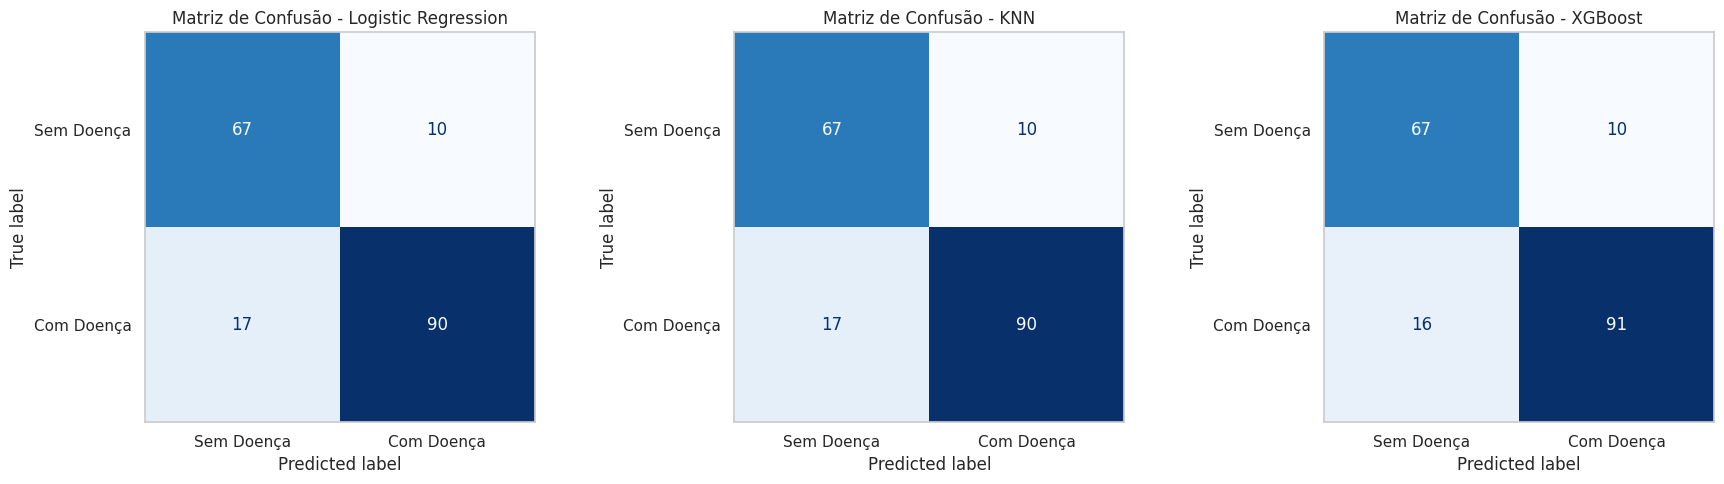

In [107]:
#Matriz de confus√£o
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

for ax, (name, model) in zip(axes, models.items()):
    if name == 'XGBoost':
        y_pred = model.predict(X_test)
    else:
        y_pred = model.predict(X_test_scaled)

    cm = confusion_matrix(y_test, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Sem Doen√ßa', 'Com Doen√ßa'])
    disp.plot(ax=ax, cmap='Blues', colorbar=False)
    ax.set_title(f'Matriz de Confus√£o - {name}')
    ax.grid(False)

plt.tight_layout()
plt.show()

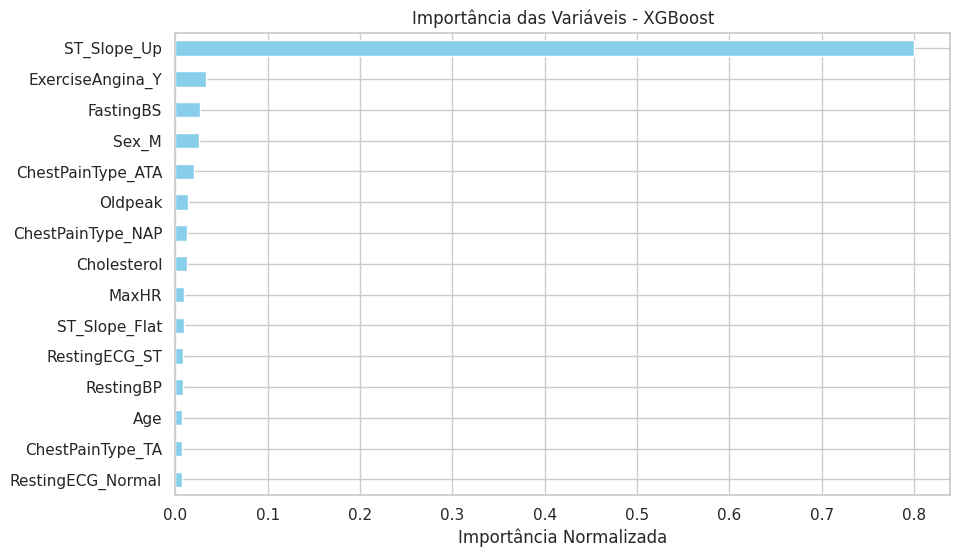

In [108]:
importances = xgb_model.feature_importances_
normalized_importances = importances / importances.sum()

feat_importances = pd.Series(normalized_importances, index=X.columns)

# Gr√°fico das 15 vari√°veis mais importantes para o modelo XGBoost na predi√ß√£o da doen√ßa card√≠aca
plt.figure(figsize=(10, 6))
feat_importances.nlargest(15).sort_values().plot(kind='barh', color='skyblue')
plt.title("Import√¢ncia das Vari√°veis - XGBoost")
plt.xlabel("Import√¢ncia Normalizada")
plt.show()

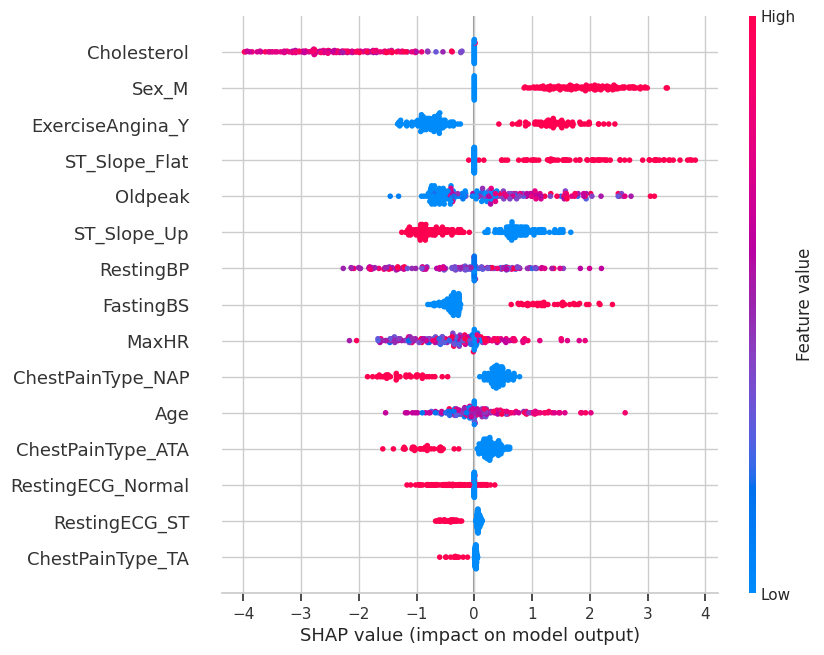

In [109]:
#Sharp
explainer = shap.Explainer(xgb_model, X_test_scaled)
shap_values = explainer(X_test)

shap.plots.beeswarm(shap_values, max_display=15)

# Resultados com Interpreta√ß√£o SHAP

A an√°lise explorat√≥ria revelou diferen√ßas relevantes nas caracter√≠sticas cl√≠nicas entre pacientes sobreviventes e n√£o sobreviventes com falha card√≠aca.

O modelo preditivo, com destaque para o XGBoost, apresentou bom desempenho nas m√©tricas avaliadas.

A interpreta√ß√£o pelo SHAP indicou que as vari√°veis que mais impactaram a predi√ß√£o foram:

- **Colesterol (Cholesterol)**: n√≠veis elevados tiveram grande influ√™ncia na previs√£o do modelo.
- **Sexo masculino (Sex_M)**: mostrou-se um importante fator preditivo.
- **Presen√ßa de angina induzida por exerc√≠cio (ExerciseAngina_Y)**: contribuiu significativamente para a decis√£o do modelo.
- Outras vari√°veis, como idade, fra√ß√£o de eje√ß√£o e press√£o arterial sist√≥lica, tiveram impacto menor na interpreta√ß√£o pelo SHAP para este modelo espec√≠fico.

Esses resultados refor√ßam a interpretabilidade e a capacidade do modelo em capturar padr√µes relevantes para o diagn√≥stico de falha card√≠aca, alinhados com as caracter√≠sticas cl√≠nicas analisadas.


# Conclus√£o

# Conclus√£o

A an√°lise demonstrou que certos indicadores cl√≠nicos, como colesterol, sexo masculino e angina induzida por esfor√ßo, t√™m maior impacto na previs√£o do risco de falha card√≠aca, segundo a explicabilidade fornecida pelo SHAP. Ainda que vari√°veis tradicionalmente importantes como idade e fra√ß√£o de eje√ß√£o tamb√©m influenciem as decis√µes do modelo, sua contribui√ß√£o foi relativamente menor no modelo final treinado.

Entre os modelos avaliados, o **XGBoost** apresentou o melhor desempenho geral no conjunto de teste (Accuracy = 0.859, F1 Score = 0.875), embora a **Regress√£o Log√≠stica** tenha se destacado na valida√ß√£o cruzada com a maior AUC m√©dia (0.9226), indicando maior estabilidade e generaliza√ß√£o no treino.

Todos os modelos obtiveram **alta √°rea sob a curva ROC (AUC > 0.92)**, demonstrando boa capacidade discriminativa. Os resultados tamb√©m mostraram **bom equil√≠brio entre sensibilidade e precis√£o**, o que √© essencial em contextos cl√≠nicos, onde tanto falsos negativos quanto falsos positivos podem trazer riscos ao paciente.

A interpreta√ß√£o com SHAP refor√ßa a utilidade dessas abordagens preditivas como **ferramentas transparentes de apoio √† decis√£o m√©dica**, possibilitando identificar padr√µes complexos e auxiliar na **detec√ß√£o precoce de pacientes com maior risco de falha card√≠aca**, contribuindo potencialmente para estrat√©gias de interven√ß√£o mais eficazes e personalizadas.
